In [1]:
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import arviz as az

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\David\OneDrive\repos\bayesian_notes\bayes\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
%config InlineBackend.figure_format = 'retina'
az.style.use('arviz-darkgrid')

#### Code 3.1

$$Pr(vampire|positive) = \frac{Pr(positive|vampire) Pr(vampire)} {Pr(positive)}$$

$$Pr(positive) = Pr(positive|vampire) Pr(vampire) + Pr(positive|mortal) 1 − Pr(vampire)$$

In [3]:
PrPV = 0.95
PrPM = 0.01
PrV = 0.001
PrP = PrPV * PrV + PrPM * (1 - PrV)
PrVP = PrPV * PrV / PrP
PrVP

0.08683729433272395

#### Code 3.2 - 3.5

We are goint to use the same function we use on chapter 2 (code 2.3)

In [4]:
def posterior_grid_approx(grid_points=100, success=6, tosses=9):
    """
    """
    # define grid
    p_grid = np.linspace(0, 1, grid_points)

    # define prior
    prior = np.repeat(5, grid_points)  # uniform
    #prior = (p_grid >= 0.5).astype(int)  # truncated
    #prior = np.exp(- 5 * abs(p_grid - 0.5))  # double exp

    # compute likelihood at each point in the grid
    likelihood = stats.binom.pmf(success, tosses, p_grid)

    # compute product of likelihood and prior
    unstd_posterior = likelihood * prior

    # standardize the posterior, so it sums to 1
    posterior = unstd_posterior / unstd_posterior.sum()
    return p_grid, posterior

In [5]:
p_grid, posterior = posterior_grid_approx(grid_points=100, success=6, tosses=9)
samples = np.random.choice(p_grid, p=posterior, size=int(1e4), replace=True)

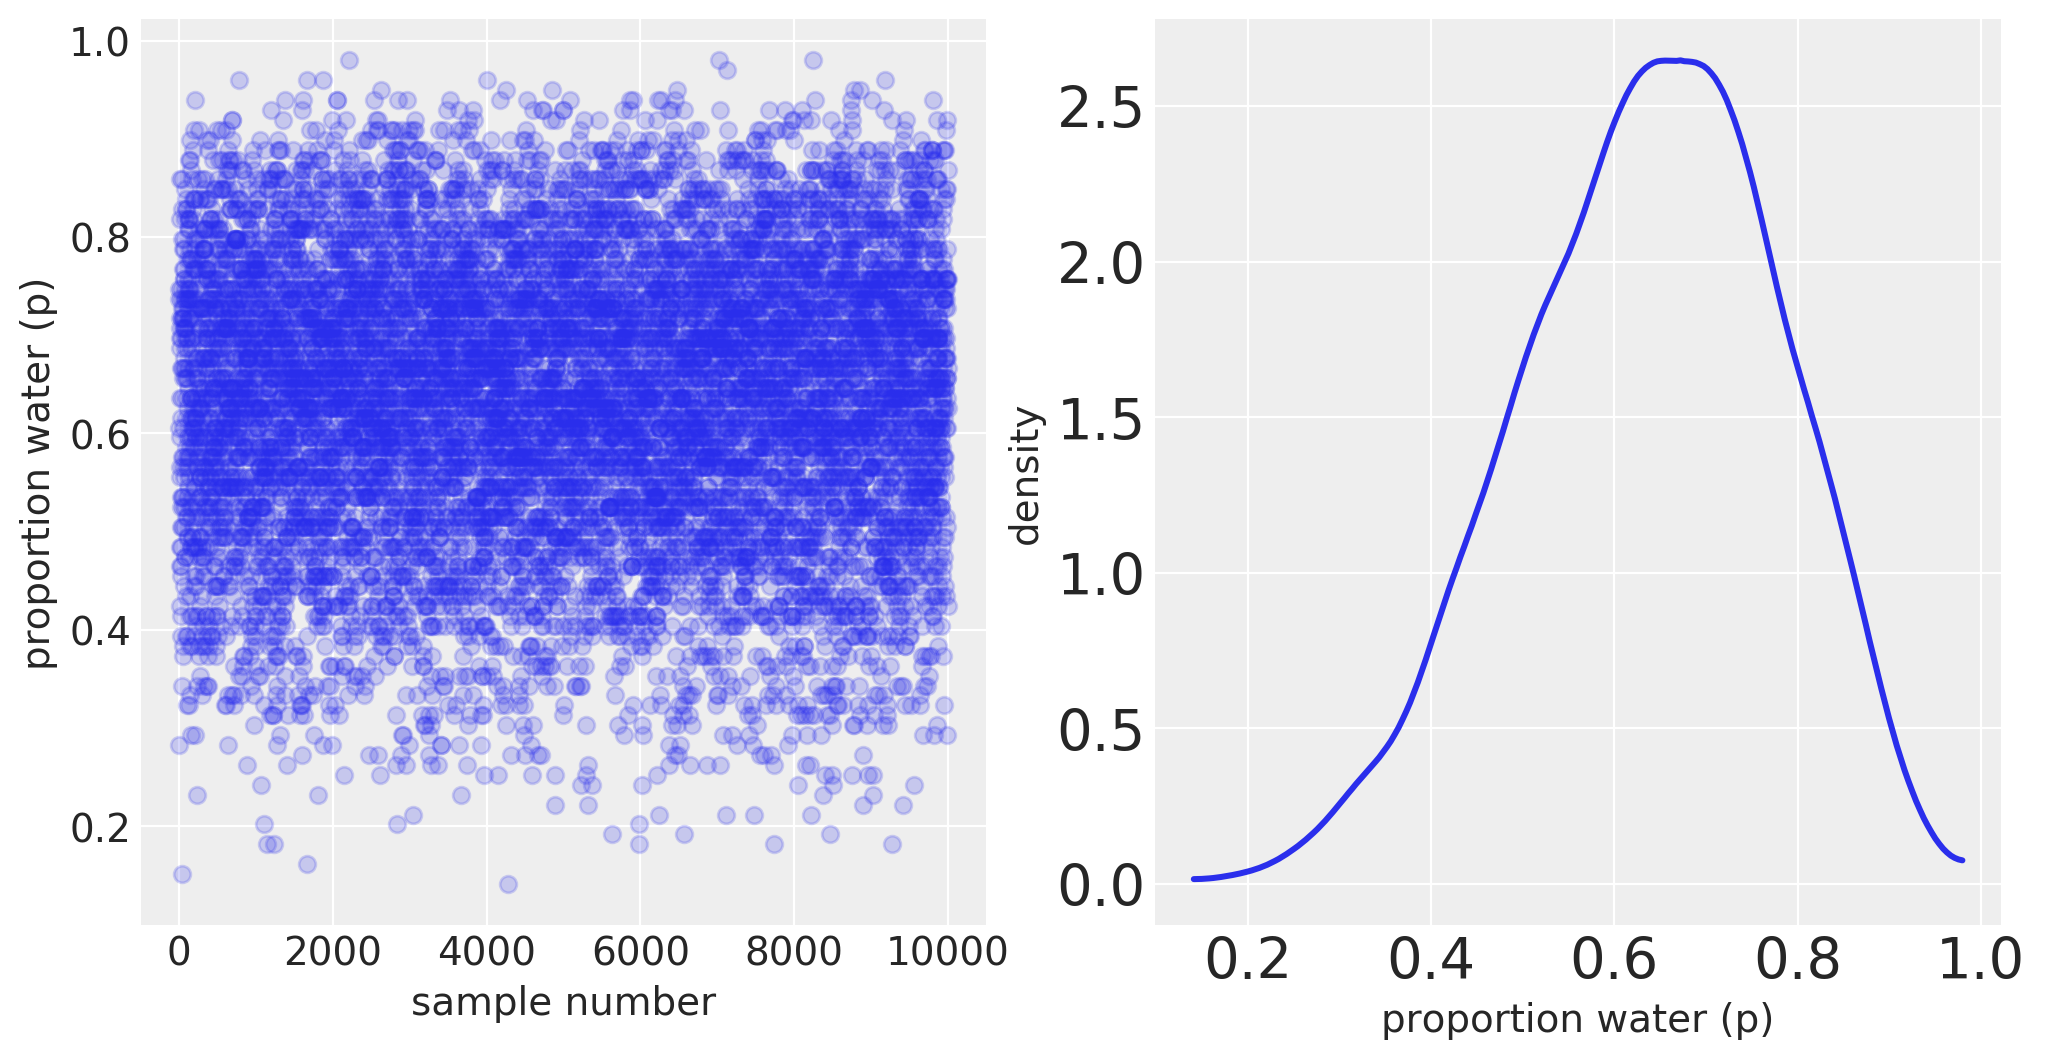

In [6]:
_, (ax0, ax1) = plt.subplots(1,2, figsize=(12,6))
ax0.plot(samples, 'o', alpha=0.2)
ax0.set_xlabel('sample number', fontsize=14)
ax0.set_ylabel('proportion water (p)', fontsize=14)
az.plot_kde(samples, ax=ax1)
ax1.set_xlabel('proportion water (p)', fontsize=14)
ax1.set_ylabel('density', fontsize=14);

#### Code 3.6

In [7]:
sum(posterior[ p_grid < 0.5 ])

0.17183313110747478

#### Code 3.7

In [8]:
sum( samples < 0.5 ) / 1e4

0.1752

#### Code 3.8

In [9]:
sum((samples > 0.5) & (samples < 0.75)) / 1e4

0.6084

#### Figure 3.2



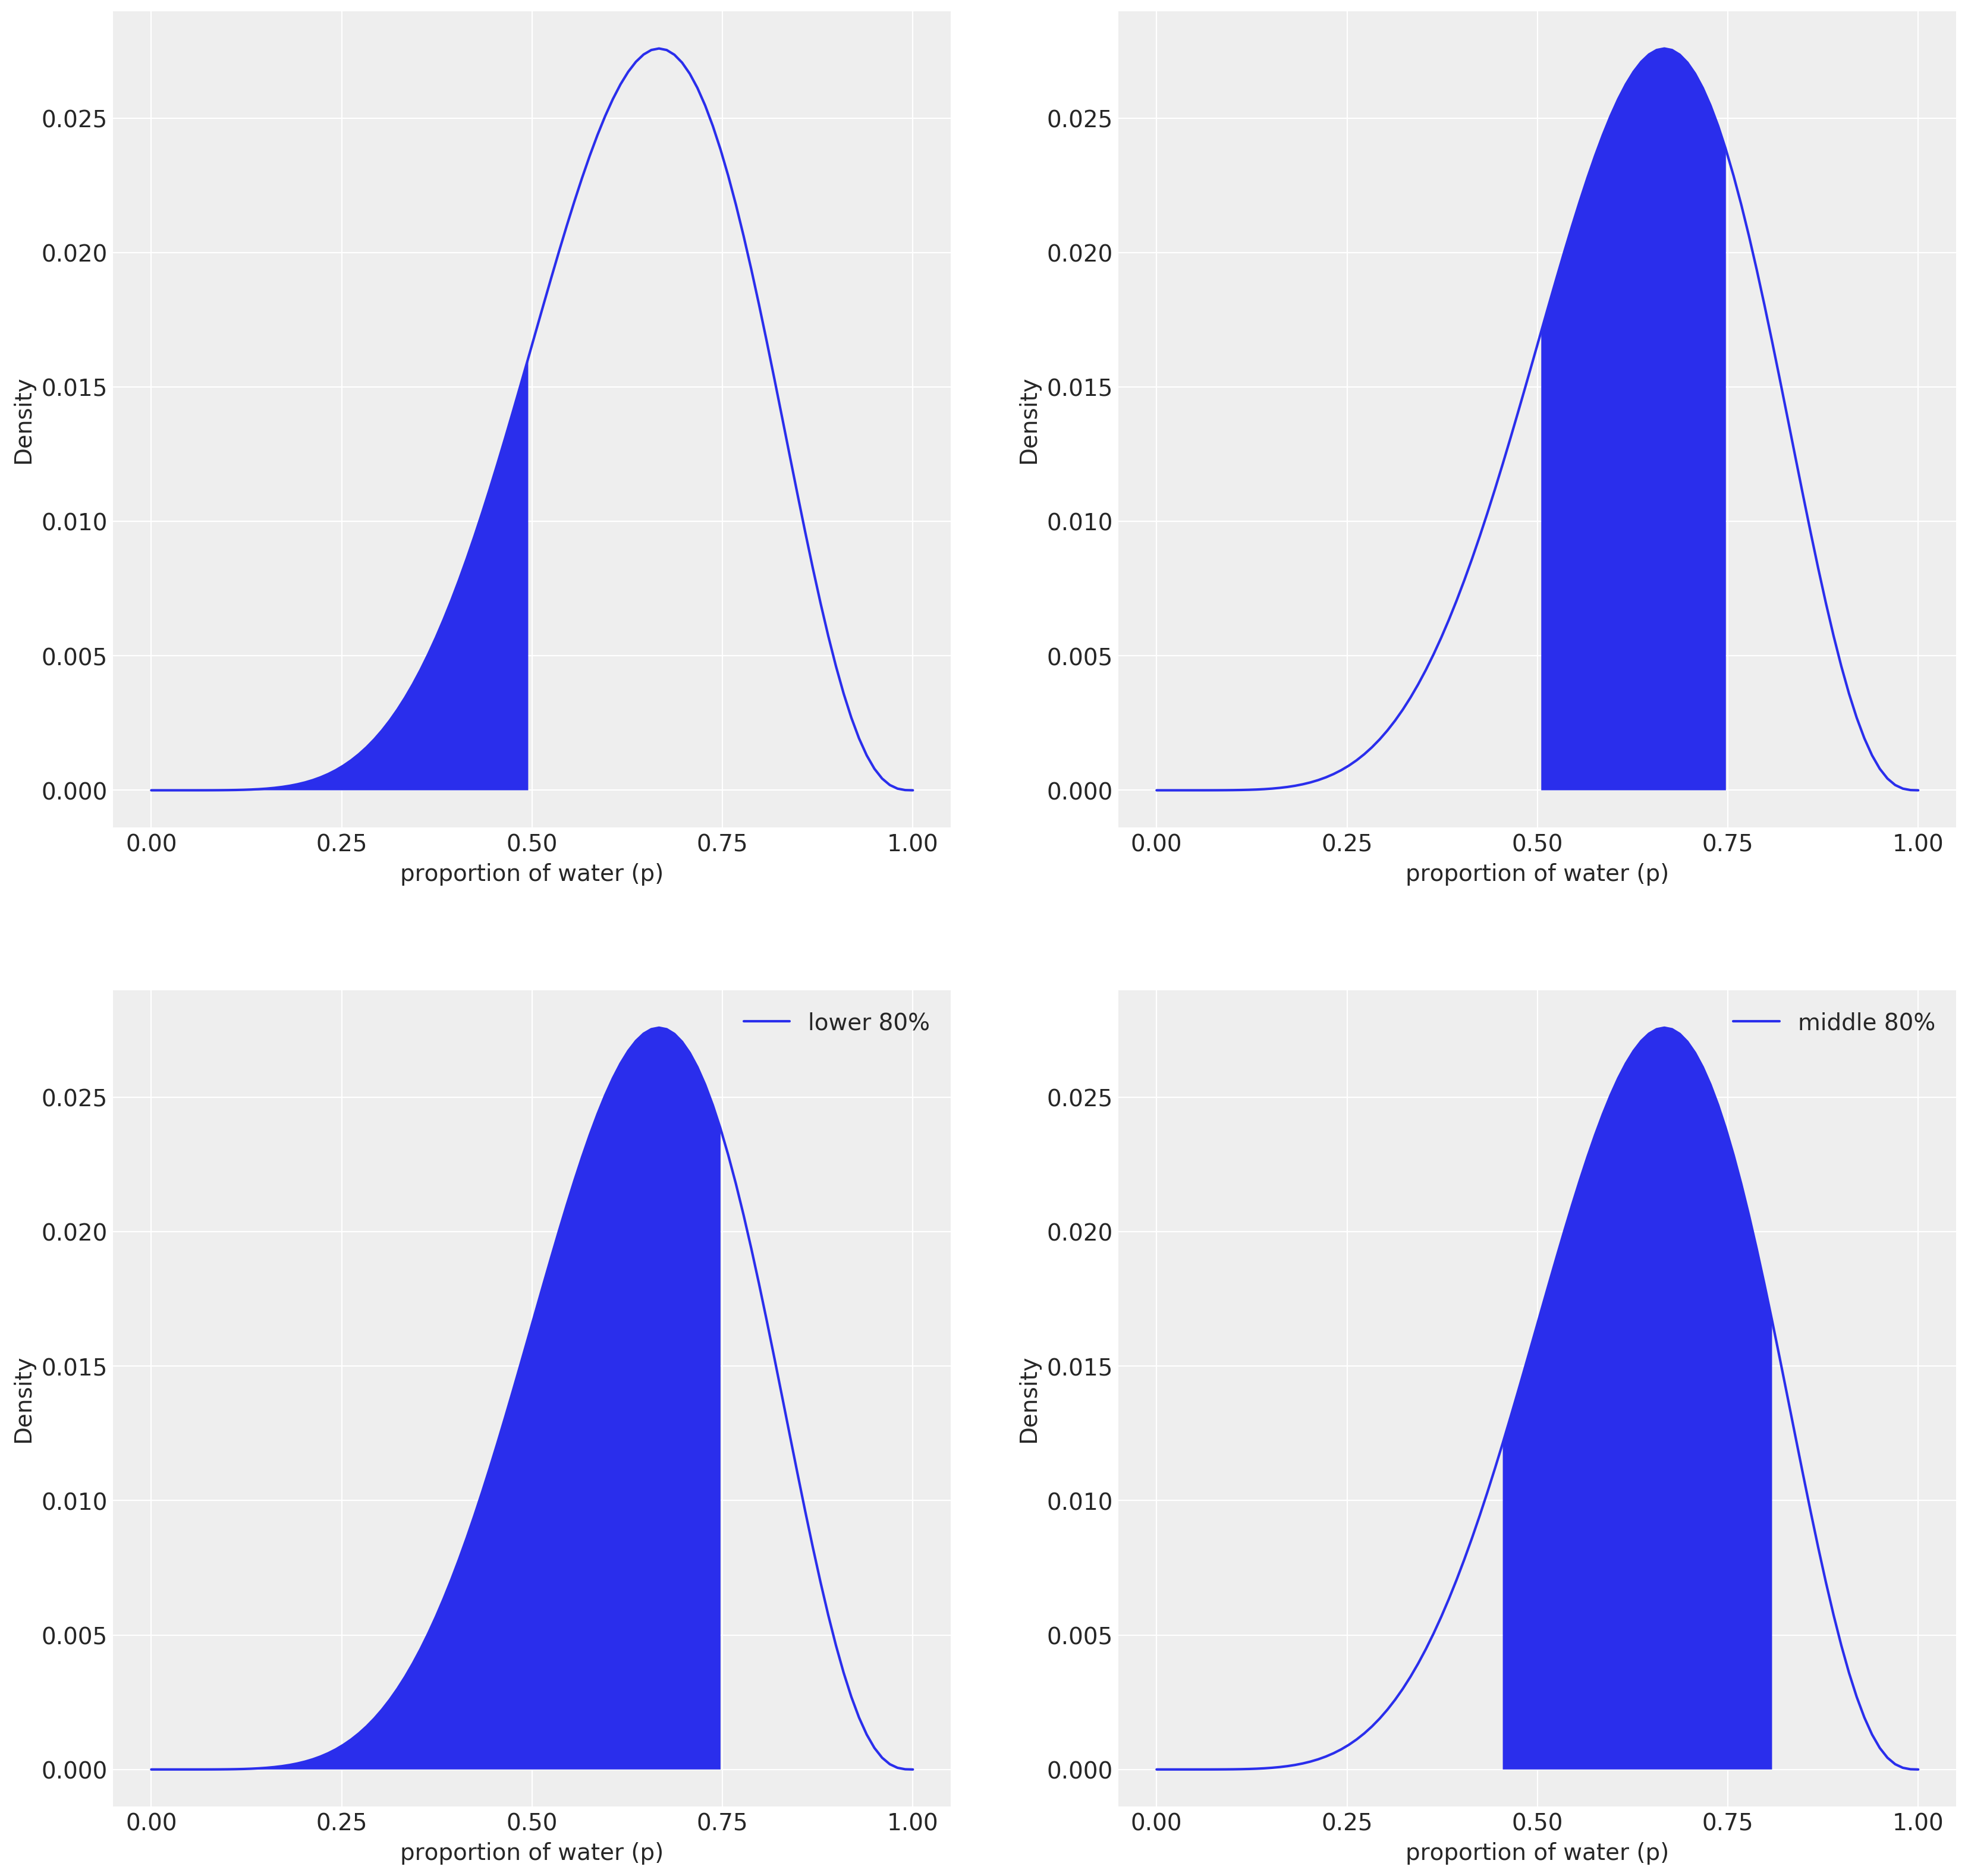

In [10]:
# plotting out intervals of defined boundaries: 

# wider figure
plt.figure(figsize=(20,20)) 

### Intervals of defined boundaries:

# plot p < 0.5
plt.subplot(2, 2, 1)
plt.plot(p_grid, posterior)
plt.xlabel('proportion of water (p)', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.xticks([0,0.25,0.50,0.75,1.00])
plt.fill_between(p_grid, posterior, where = p_grid < 0.5)

# plot p < 0.5 & p > 0.75
plt.subplot(2, 2, 2)
plt.plot(p_grid, posterior)
plt.xlabel('proportion of water (p)', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.xticks([0,0.25,0.50,0.75,1.00])
plt.fill_between(p_grid, posterior, where = (p_grid > 0.5)&(p_grid < 0.75))

### Intervals of defined mass:

# plot p < 0.5
plt.subplot(2, 2, 3)
plt.plot(p_grid, posterior, label = "lower 80%")
plt.xlabel('proportion of water (p)', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.xticks([0,0.25,0.50,0.75,1.00])
plt.fill_between(p_grid, posterior, where = p_grid < np.percentile(samples, 80))
plt.legend(loc=0)

# plot p < 0.5 & p > 0.75
perc_range = np.percentile(samples, [10, 90])
plt.subplot(2, 2, 4)
plt.plot(p_grid, posterior,label = "middle 80%")
plt.xlabel('proportion of water (p)', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.xticks([0,0.25,0.50,0.75,1.00])
plt.fill_between(p_grid, posterior, where = (p_grid > perc_range[0])&(p_grid < perc_range[1]))
plt.legend(loc=0)

plt.show()

#### Code 3.9

In [12]:
np.percentile(samples, 80)

0.7575757575757577

#### Code 3.10

In [13]:
np.percentile(samples, [10, 90])

array([0.44444444, 0.81818182])

#### Code 3.11

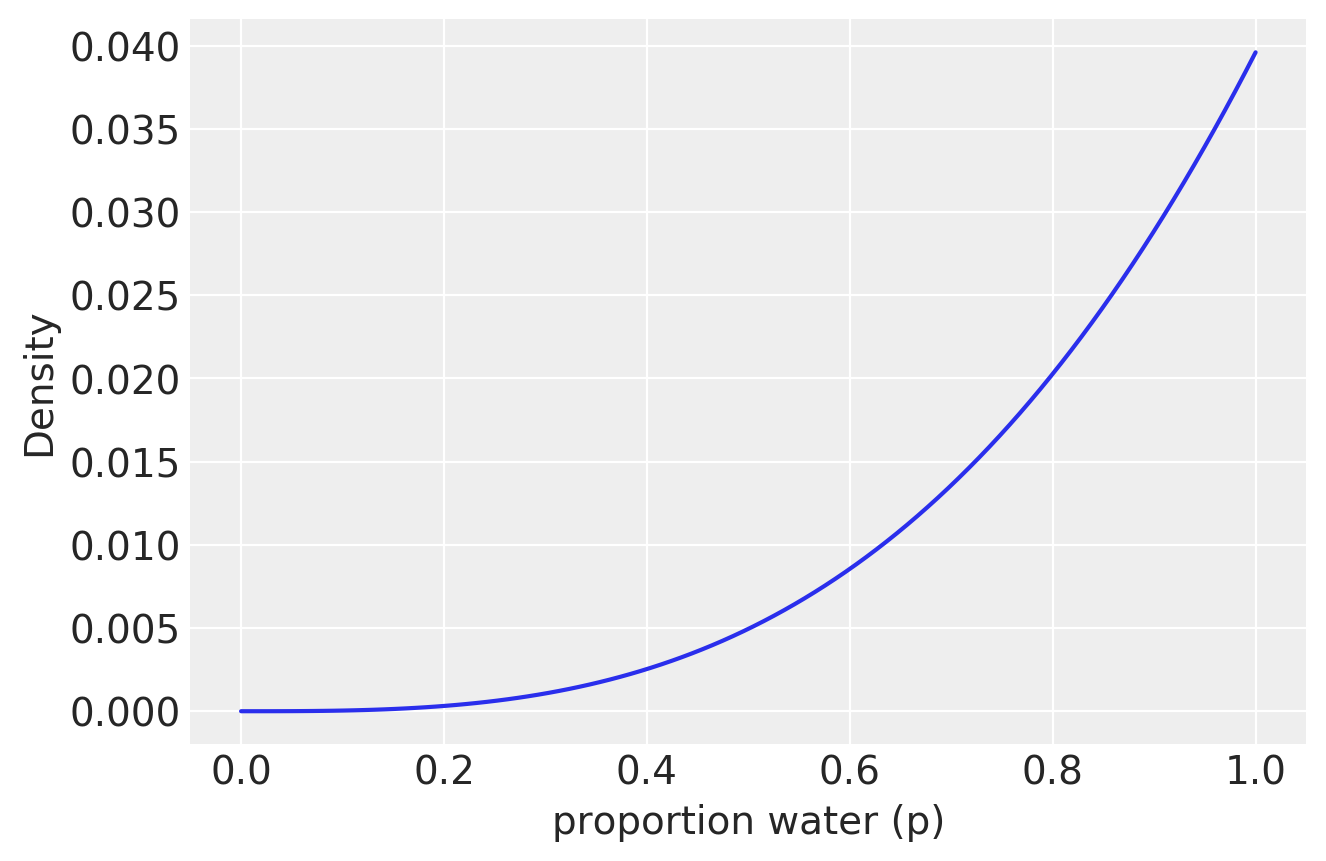

In [14]:
p_grid, posterior = posterior_grid_approx(success=3, tosses=3)
plt.plot(p_grid, posterior)
plt.xlabel('proportion water (p)', fontsize=14)
plt.ylabel('Density', fontsize=14);

#### Code 3.12

In [15]:
samples = np.random.choice(p_grid, p=posterior, size=int(1e4), replace=True)
np.percentile(samples, [25, 75])

array([0.71717172, 0.93939394])

#### Code 3.13

In [17]:
az.hpd(samples, credible_interval=0.5)

array([0.84848485, 1.        ])

#### Figure 3.3 

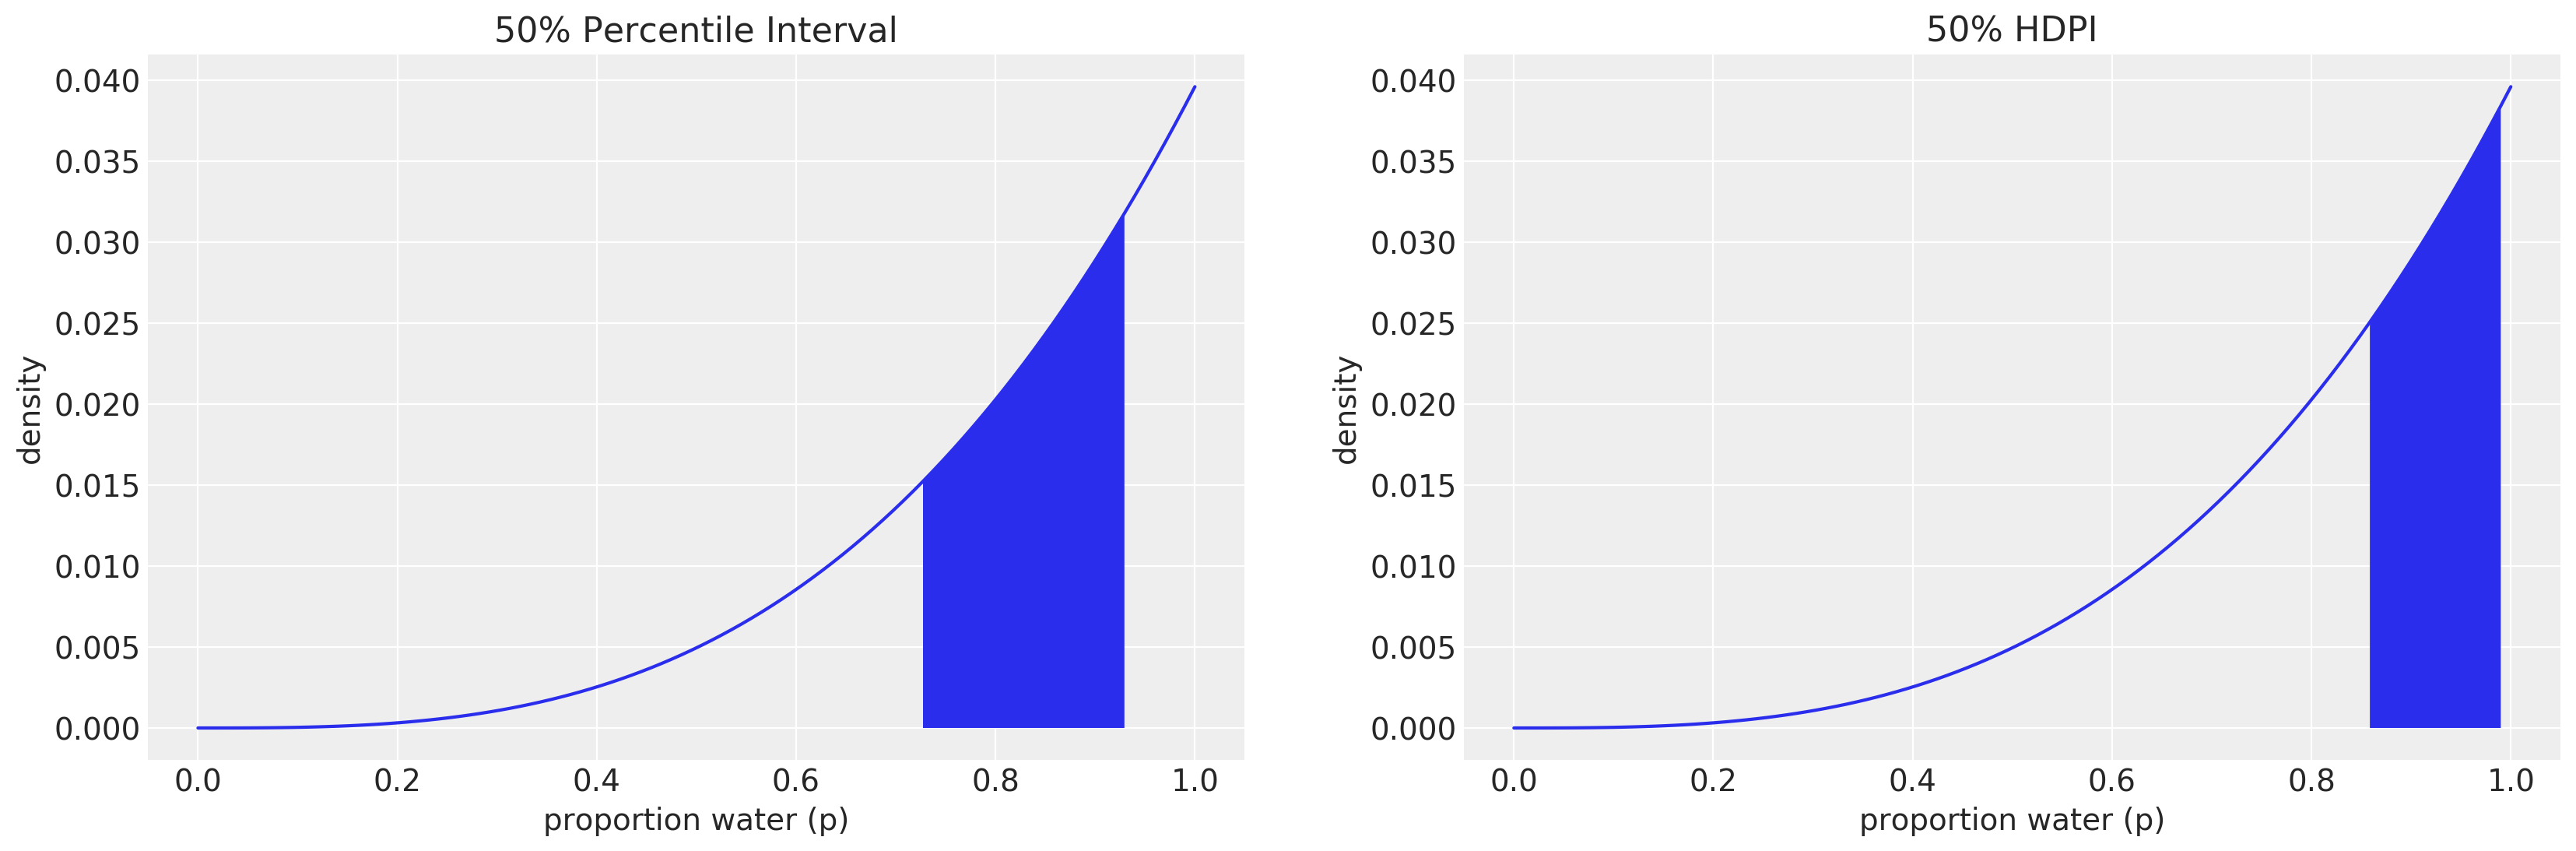

In [19]:
# wider figure
plt.figure(figsize=(20,6)) 

# calculate posterior: 
p_grid, posterior = posterior_grid_approx(success=3, tosses=3)

# PI
pi_interval = np.percentile(samples, [25, 75])

# PI Plot
plt.subplot(1, 2, 1)
plt.plot(p_grid, posterior)
plt.xlabel('proportion water (p)', fontsize=14)
plt.ylabel('density', fontsize=14)
plt.fill_between(p_grid, posterior, where = (p_grid > pi_interval[0]) & (p_grid < pi_interval[1]))
plt.title(f'50% Percentile Interval')

# HDPI
hdpi_interval = az.hpd(samples, credible_interval=0.5)

# HDPI Plot
plt.subplot(1, 2, 2)
plt.plot(p_grid, posterior)
plt.xlabel('proportion water (p)', fontsize=14)
plt.ylabel('density', fontsize=14)
plt.fill_between(p_grid, posterior, where = (p_grid > hdpi_interval[0]) & (p_grid < hdpi_interval[1]))
plt.title(f'50% HDPI')

plt.show()

#### Code 3.14

In [20]:
p_grid[posterior == max(posterior)]

array([1.])

#### Code 3.15

In [21]:
stats.mode(samples)[0]

array([0.98989899])

#### Code 3.16

In [22]:
np.mean(samples), np.median(samples)

(0.8072343434343434, 0.8484848484848485)

#### Code 3.17

In [23]:
sum(posterior * abs(0.5 - p_grid))

0.31626874808692995

#### Code 3.18 and 3.19

In [24]:
loss = [sum(posterior * abs(p - p_grid)) for p in p_grid]
p_grid[loss == min(loss)]

array([0.84848485])

#### A portion of Figure 3.4

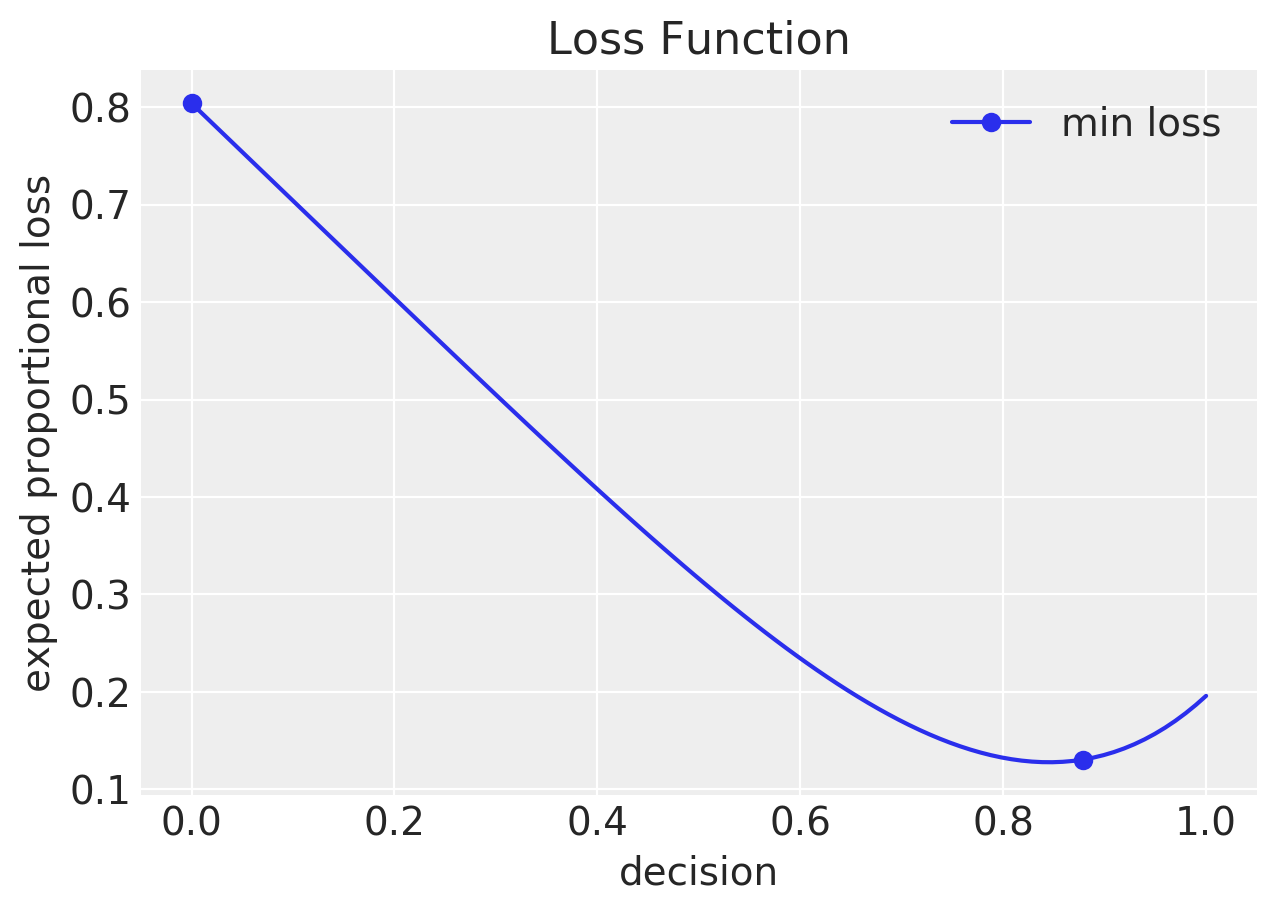

In [25]:
plt.plot(p_grid, loss, markevery =p_grid[loss == min(loss)][0], marker = "o", label = "min loss")
plt.xlabel('decision', fontsize=14)
plt.ylabel('expected proportional loss', fontsize=14)
plt.title(f'Loss Function')
plt.legend(loc=0)
plt.show()

#### Code 3.20

In [21]:
stats.binom.pmf(range(3), n=2, p=0.7)

array([0.09, 0.42, 0.49])

#### Code 3.21

In [22]:
stats.binom.rvs(n=2, p=0.7, size=1)

array([2])

#### Code 3.22

In [23]:
stats.binom.rvs(n=2, p=0.7, size=10)

array([2, 2, 2, 0, 1, 1, 2, 1, 2, 2])

#### Code 3.23

In [24]:
dummy_w = stats.binom.rvs(n=2, p=0.7, size=int(1e5))
[(dummy_w == i).mean() for i in range(3)]

[0.08921, 0.42152, 0.48927]

#### Code 3.24, 3.25 and 3.26

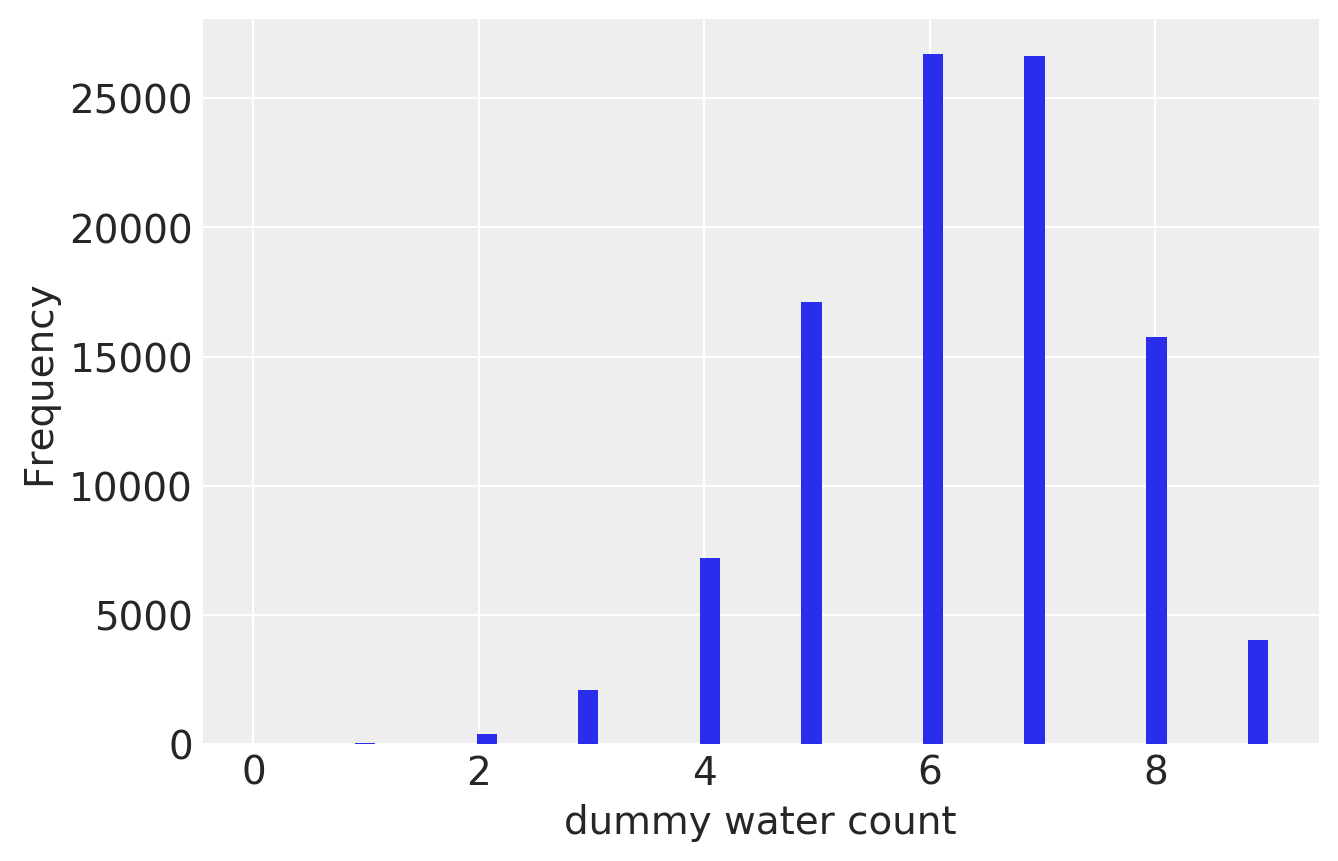

In [25]:
dummy_w = stats.binom.rvs(n=9, p=0.7, size=int(1e5))
#dummy_w = stats.binom.rvs(n=9, p=0.6, size=int(1e4))
#dummy_w = stats.binom.rvs(n=9, p=samples)
plt.hist(dummy_w, bins=50)
plt.xlabel('dummy water count', fontsize=14)
plt.ylabel('Frequency', fontsize=14);

#### Code 3.27

In [26]:
p_grid, posterior = posterior_grid_approx(grid_points=100, success=6, tosses=9)
np.random.seed(100)
samples = np.random.choice(p_grid, p=posterior, size=int(1e4), replace=True)

#### Code 3.28

In [27]:
birth1 = np.array([1,0,0,0,1,1,0,1,0,1,0,0,1,1,0,1,1,0,0,0,1,0,0,0,1,0, 0,0,0,1,1,1,0,1,0,1,1,1,0,1,0,1,1,0,1,0,0,1,1,0,1,0,0,0,0,0,0,0, 1,1,0,1,0,0,1,0,0,0,1,0,0,1,1,1,1,0,1,0,1,1,1,1,1,0,0,1,0,1,1,0,1,0,1,1,1,0,1,1,1,1])
birth2 = np.array([0,1,0,1,0,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,0,0,1,1,1,0,
1,1,1,0,1,1,1,0,1,0,0,1,1,1,1,0,0,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,
1,1,1,0,1,1,0,1,1,0,1,1,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,1,1,
0,0,0,1,1,1,0,0,0,0])

#### Code 3.29

#### Code 3.30

In [28]:
sum(birth1) + sum(birth2)

111

In [29]:
import sys, IPython, scipy, matplotlib, platform
print("""This notebook was created using:\nPython {}\nIPython {}\nPyMC3 {}\nArviZ {}\nNumPy {}\nSciPy {}\nMatplotlib {}\n""".format(sys.version[:5], IPython.__version__, pm.__version__, az.__version__, np.__version__, scipy.__version__, matplotlib.__version__))

This notebook was created using:
Python 3.7.2
IPython 7.9.0
PyMC3 3.7
ArviZ 0.5.1
NumPy 1.17.3
SciPy 1.3.1
Matplotlib 3.1.1

